In [ ]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
from entropy_bounds.utils import optimization_cf
from binaryIV import simulate_deterministic_data_with_probabilistic_ate, extract_prob_dict, entropy_of_array



import matplotlib.pyplot as plt
import seaborn as sns
import math
from linearmodels.iv import IV2SLS
import statsmodels.api as sm

pd.options.mode.chained_assignment = None  # default='warn'




In [122]:
def plot_smoothed_ate_vs_ci(dataframe, window=1):
    """
    Plot smoothed ATE_true and 2SLS confidence intervals from the given dataframe.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing columns 'ATE_true', '2SLS_CI_lower', '2SLS_CI_upper', and 'b_X_Y'.
    window (int): The size of the rolling window for smoothing. Default is 1.

    Returns:
    None
    """
    # Smoothen the data using a rolling average
    dataframe['ATE_true_smooth'] = dataframe['ATE_true'].rolling(window=window, center=True).mean()
    dataframe['2SLS_CI_lower_smooth'] = dataframe['2SLS_CI_lower'].rolling(window=window, center=True).mean()
    dataframe['2SLS_CI_upper_smooth'] = dataframe['2SLS_CI_upper'].rolling(window=window, center=True).mean()

    # Plot the smoothed data
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=dataframe, x='b_X_Y', y='ATE_true_smooth', label='$ATE_{true}$', color='blue')
    sns.lineplot(data=dataframe, x='b_X_Y', y='2SLS_CI_lower_smooth', label='Lower CI', color='orange')
    sns.lineplot(data=dataframe, x='b_X_Y', y='2SLS_CI_upper_smooth', label='Upper CI', color='green')
    plt.axhline(0, color='red', linestyle='--', label='Zero Line')
    plt.title('2SLS CI vs $ATE_{true}$ (smoothed out)')
    plt.xlabel('b_X_Y Coefficient')
    plt.ylabel('ATE Value')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
sim = simulate_deterministic_data_with_probabilistic_ate()

df = pd.DataFrame({'Y': sim['Y'], 'X': sim['X'], 'Z': sim['Z']})

# Add a constant term for the exogenous variables
df['const'] = 1  # Adding a constant column

# Define the dependent variable (Y), endogenous variable (X), exogenous variable (constant), and instrument (Z)
dependent = df['Y']
endog = df['X']
exog = df[['const']]  # Exogenous variables (constant term)
instruments = df['Z']

# Perform 2SLS regression
model = IV2SLS(dependent, exog, endog, instruments).fit()

CI_level = 0.95
# Print the results
print('ATE true:', sim['ATE_true'])
print(model.summary)
print('Coefficient for X:', model.params['X'])
print('Lower CI for X:', model.conf_int(level=CI_level).loc['X']['lower'])
print('Upper CI for X:', model.conf_int(level=CI_level).loc['X']['upper'])
print('Confidence Interval computed for 1-alpha =', CI_level)

ATE true: -0.1195867672579943
                          IV-2SLS Estimation Summary                          
Dep. Variable:                      Y   R-squared:                     -0.0383
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0404
No. Observations:                 500   F-statistic:                    0.5301
Date:                Sat, Apr 26 2025   P-value (F-stat)                0.4666
Time:                        15:32:52   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.5985     0.0512     11.690     0.0000      0.4982      0.6988
X              0.1250 

In [16]:
data = pd.read_pickle('binaryIV_results.pkl')

In [120]:
df_results = data.copy()
CI_level = 0.98
for idx, observation in df_results.iterrows(): 

    #randomize CI level
    # CI_level = np.random.uniform(0.95, 0.99)

    df = pd.DataFrame({'Y': observation['Y'], 'X': observation['X'], 'Z': observation['Z']})

    # Add a constant term for the exogenous variables
    df['const'] = 1  # Adding a constant column

    # Define the dependent variable (Y), endogenous variable (X), exogenous variable (constant), and instrument (Z)
    dependent = df['Y']
    endog = df['X']
    exog = df[['const']]  # Exogenous variables (constant term)
    instruments = df['Z']

    # Perform 2SLS regression
    model = IV2SLS(dependent, exog, endog, instruments).fit()


    CI_upper =  model.conf_int(level=CI_level).loc['X']['upper']
    if CI_upper > 1:
        CI_upper = 1

    CI_lower = model.conf_int(level=CI_level).loc['X']['lower']
    if CI_lower < -1:
        CI_lower = -1

    CI_valid = CI_lower <= observation['ATE_true'] <= CI_upper

    df_results.at[idx, '2SLS_CI_level_percent'] = CI_level*100
    df_results.at[idx, '2SLS_estimation'] = model.params['X']
    df_results.at[idx, '2SLS_CI_lower'] = CI_lower
    df_results.at[idx, '2SLS_CI_upper'] = CI_upper
    df_results.at[idx, '2SLS_CI_width'] = CI_upper - CI_lower
    df_results.at[idx, '2SLS_CI_valid'] = CI_valid
    



In [97]:
### OLS: CI_lvl --> CI_width
df_ols = df_results.copy()

# Add a constant for the intercept
df_ols['corr_X_Y_squared'] = df_ols['corr_X_Y'] ** 2
df_ols['corr_X_Z_squared'] = df_ols['corr_X_Z'] ** 2
df_ols['2SLS_CI_level_percent_squared'] = df_ols['2SLS_CI_level_percent'] ** 2

X = sm.add_constant(df_ols[['2SLS_CI_level_percent']])	
y = df_ols['2SLS_CI_width']

# Fit the OLS model
ols_model = sm.OLS(y, X).fit()

ols_robust = ols_model.get_robustcov_results(cov_type='HC1')
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          2SLS_CI_width   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     25.39
Date:                Sun, 27 Apr 2025   Prob (F-statistic):           5.10e-07
Time:                        14:32:00   Log-Likelihood:                -1334.4
No. Observations:                2000   AIC:                             2673.
Df Residuals:                    1998   BIC:                             2684.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.52

In [119]:
import statsmodels.api as sm
import numpy as np

# Copy and prepare data
df_ols = df_results.copy()

X = sm.add_constant(df_ols[['2SLS_CI_level_percent']])
df_ols['2SLS_CI_invalid'] = df_ols['2SLS_CI_valid'].replace({True: 0, False: 1})
y = df_ols['2SLS_CI_invalid']

# Fit logistic regression
logit_model = sm.Logit(y, X).fit()

# Print marginal effects
mfx = logit_model.get_margeff()
print(logit_model.summary())

# ---- NEW: Extract coefficients ----
params = logit_model.params
intercept = params['const']
slope = params['2SLS_CI_level_percent']

print(f"Intercept: {intercept:.5f}")
print(f"Slope: {slope:.5f}")

# ---- NEW: Solve for CI level for 1% error ----

# Target probability of invalid CI
target_error = 0.01  # 1%

# Invert the logistic function
# logit(p) = intercept + slope * CI_level
# So: CI_level = (log(p / (1 - p)) - intercept) / slope

logit_target = np.log(target_error / (1 - target_error))
required_CI_level = (logit_target - intercept) / slope

print(f"Required CI Level (percent): {required_CI_level:.2f}%")


Optimization terminated successfully.
         Current function value: 0.075651
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:        2SLS_CI_invalid   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1998
Method:                           MLE   Df Model:                            1
Date:                Sun, 27 Apr 2025   Pseudo R-squ.:                 0.02865
Time:                        15:19:53   Log-Likelihood:                -151.30
converged:                       True   LL-Null:                       -155.77
Covariance Type:            nonrobust   LLR p-value:                  0.002812
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    43.6137     16.697      2.612      0.009      10.888      76.

C:\Users\tmari\AppData\Local\Temp\ipykernel_17448\2317288809.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ols['2SLS_CI_invalid'] = df_ols['2SLS_CI_valid'].replace({True: 0, False: 1})


Corr(causaloptim_width, 2SLS_width): 0.8052245229737477
num invalid: 16
Corr(causaloptim_valid, 2SLS_valid): -0.004495755762078434
Invalid rate: 0.008
AvG CI width: 0.9622957678084018
N:  1984


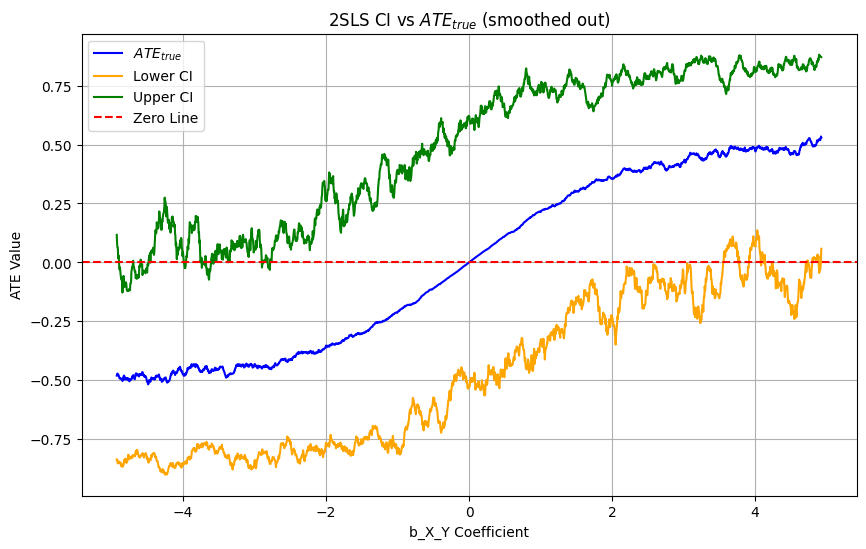

In [ ]:
pd.set_option('display.max_columns', None)
print("Corr(causaloptim_width, 2SLS_width):", df_results['causaloptim_bound_width'].corr(df_results['2SLS_CI_width']))
###Invalid rate
invalid_rate = df_results[df_results['2SLS_CI_valid'] == False].shape[0] / df_results.shape[0]
print('num invalid:', df_results[df_results['2SLS_CI_valid'] == False].shape[0])
print('Corr(causaloptim_valid, 2SLS_valid):', df_results['causaloptim_bounds_valid'].corr(df_results['2SLS_CI_valid']))
print("Invalid rate:", invalid_rate)
print('AvG CI width:', df_results['2SLS_CI_width'].mean())
no_invalids = df_results[df_results['2SLS_CI_valid'] == True]
print('N:', no_invalids.shape[0])
plot_smoothed_ate_vs_ci(no_invalids, 30)

In [93]:
CI_level = 0.985
results = []
for b_X_Y in np.arange(-5, 5, 0.005):  # Use np.arange for 0.5 steps
    sim = simulate_deterministic_data_with_probabilistic_ate(
        b_X_Y = b_X_Y
        # b_Z = np.random.normal(0, 1)
    )
    df = pd.DataFrame({'Y': sim['Y'], 'X': sim['X'], 'Z': sim['Z']})

    # Add a constant term for the exogenous variables
    df['const'] = 1  # Adding a constant column

    # Define the dependent variable (Y), endogenous variable (X), exogenous variable (constant), and instrument (Z)
    dependent = df['Y']
    endog = df['X']
    exog = df[['const']]  # Exogenous variables (constant term)
    instruments = df['Z']

    # Perform 2SLS regression
    model = IV2SLS(dependent, exog, endog, instruments).fit()

    CI_lower = model.conf_int(level=CI_level).loc['X']['lower']
    CI_upper =  model.conf_int(level=CI_level).loc['X']['upper']

    CI_valid = CI_lower <= sim['ATE_true'] <= CI_upper

    results.append({
        'b_X_Y': sim['b_X_Y'],
        'b_Z': sim['b_Z'],
        'b_U_X': sim['b_U_X'],
        'b_U_Y': sim['b_U_Y'],
        'entropy_Y': entropy_of_array(sim['Y']),
        'entropy_X': entropy_of_array(sim['X']),
        'entropy_Z': entropy_of_array(sim['Z']),
        'entropy_U': entropy_of_array(sim['U']),
        'corr_X_Y': np.corrcoef(sim['X'], sim['Y'])[0, 1],
        'corr_X_Z': np.corrcoef(sim['X'], sim['Z'])[0, 1],
        'corr_Y_Z': np.corrcoef(sim['Y'], sim['Z'])[0, 1],
        'ATE_true': sim['ATE_true'],
        '2SLS_estimation': model.params['X'],
        '2SLS_CI_lower': CI_lower,
        '2SLS_CI_upper': CI_upper,
        '2SLS_CI_width': CI_upper - CI_lower,
        '2SLS_CI_valid': CI_valid
    })


df_results = pd.DataFrame(results)


N:  1000
Average CI width: 0.654
Invalid observations: 24 ( 3.721 %)
Median CI width: 0.644


KeyboardInterrupt: 

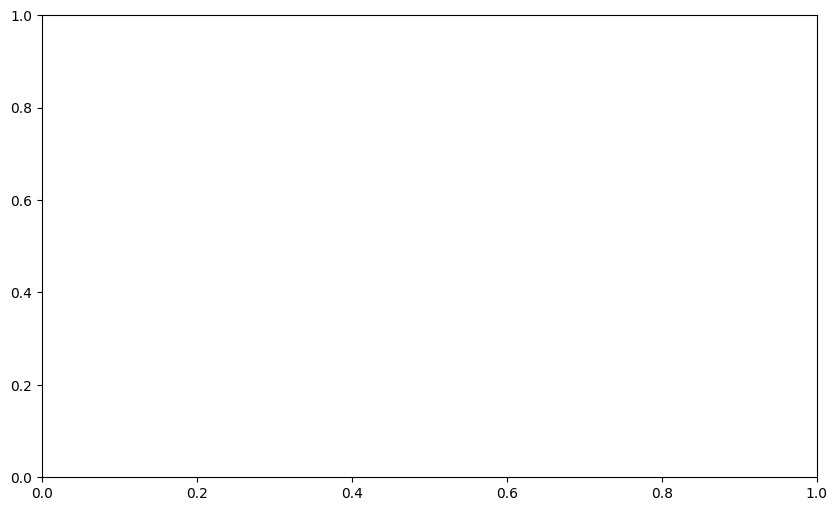

In [51]:
### dont kick anything
invalids = len(no_outliers[no_outliers['2SLS_CI_valid'] == False])
invalids_percent = (invalids / len(df_results)) * 100
print('N: ', len(df_results))
print('Average CI width:', round(no_outliers['2SLS_CI_width'].mean(), 3))
invalids = len(no_outliers[no_outliers['2SLS_CI_valid'] == False])
invalids_percent = (invalids / len(no_outliers)) * 100
print('Invalid observations:', invalids, '(', round(invalids_percent, 3), '%)')
print('Median CI width:', round(no_outliers['2SLS_CI_width'].median(), 3))
plot_smoothed_ate_vs_ci(df_results, 1)

In [94]:
### just kick out outliers (practical, we know ATE is between -1 and 1)
print('N: ', len(df_results))
no_outliers = df_results[(df_results['2SLS_CI_width'] < 1) & (df_results['2SLS_CI_width'] > -1)]
print('No Outliers:', len(no_outliers))
print('Kicked %:', format((len(df_results) - len(no_outliers)) / len(df_results) * 100))
print('Avg CI width:', round(no_outliers['2SLS_CI_width'].mean(), 3))
invalids = len(no_outliers[no_outliers['2SLS_CI_valid'] == False])
invalids_percent = (invalids / len(no_outliers)) * 100
print('Error Rate:', invalids, '(', round(invalids_percent, 3), '%)')
print('Median CI width:', round(no_outliers['2SLS_CI_width'].median(), 3))

N:  3449
No Outliers: 2037
Kicked %: 40.93940272542766
Avg CI width: 0.684
Error Rate: 26 ( 1.276 %)
Median CI width: 0.68


N: 3449
Outliers kicked: 1412 ( 40.939 %)
Invalids kicked: 26 ( 1.276 %)
Total kicked: 1438 ( 41.693 %)


C:\Users\tmari\AppData\Local\Temp\ipykernel_11156\1699586878.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['ATE_true_smooth'] = dataframe['ATE_true'].rolling(window=window, center=True).mean()
C:\Users\tmari\AppData\Local\Temp\ipykernel_11156\1699586878.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['2SLS_CI_lower_smooth'] = dataframe['2SLS_CI_lower'].rolling(window=window, center=True).mean()
C:\Users\tmari\AppData\Local\Temp\ipykernel_11156\1699586878.py:15: SettingWithCop

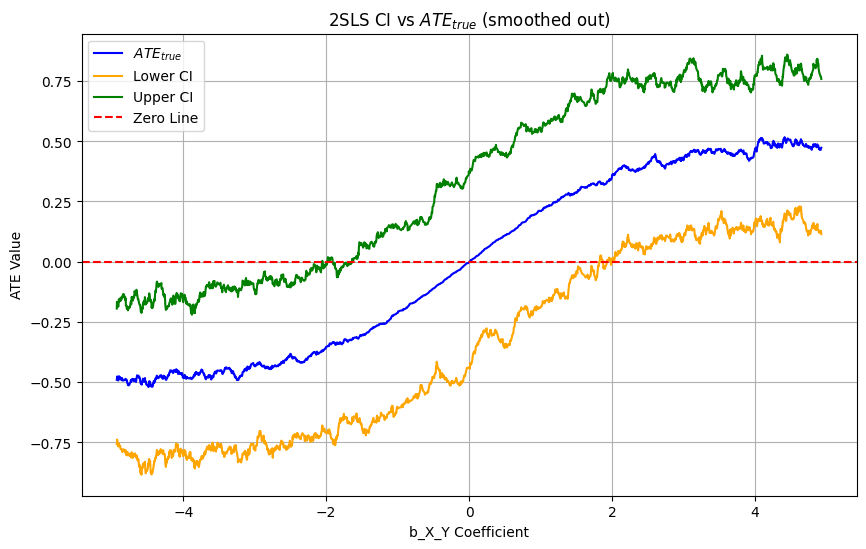

In [95]:
### kick out outliers and invalids (theoretical)

print('N:', df_results.shape[0])
no_outliers = df_results[(df_results['2SLS_CI_width'] < 1) & (df_results['2SLS_CI_width'] > -1)]
print('Outliers kicked:', len(df_results) - len(no_outliers), '(', round((len(df_results) - len(no_outliers)) / len(df_results) * 100, 3), '%)')

no_outliers_no_invalid = no_outliers.loc[no_outliers['2SLS_CI_valid'] == True]
print('Invalids kicked:', len(no_outliers) - len(no_outliers_no_invalid), '(', round((len(no_outliers) - len(no_outliers_no_invalid)) / len(no_outliers) * 100, 3), '%)')
print('Total kicked:', len(df_results) - len(no_outliers_no_invalid), '(', round((len(df_results) - len(no_outliers_no_invalid)) / len(df_results) * 100, 3), '%)')

plot_smoothed_ate_vs_ci(no_outliers_no_invalid, 30)

Invalids kicked: 31 ( 0.899 %)
Avg Bound width: 0.989
Median Bound width: 0.847


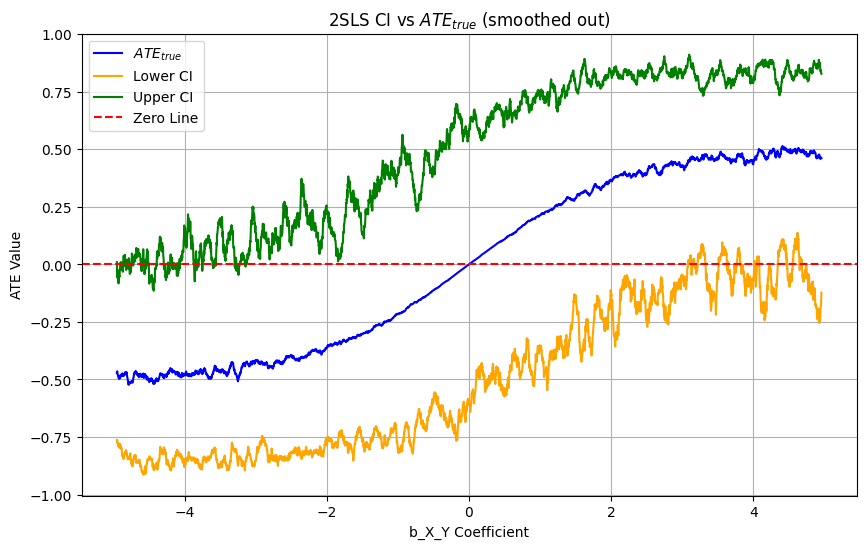

In [137]:
### dont kick out, but cap outliers

cap_outliers = df_results.copy()
cap_outliers['2SLS_CI_lower'] = np.where(cap_outliers['2SLS_CI_lower'] < -1, -1, cap_outliers['2SLS_CI_lower'])
cap_outliers['2SLS_CI_upper'] = np.where(cap_outliers['2SLS_CI_upper'] > 1, 1, cap_outliers['2SLS_CI_upper'])
cap_outliers['2SLS_CI_width'] = cap_outliers['2SLS_CI_upper'] - cap_outliers['2SLS_CI_lower']

cap_outliers_no_invalid = cap_outliers.loc[cap_outliers['2SLS_CI_valid'] == True]
print('Invalids kicked:', len(cap_outliers) - len(cap_outliers_no_invalid), '(', round((len(cap_outliers) - len(cap_outliers_no_invalid)) / len(cap_outliers) * 100, 3), '%)')
print('Avg Bound width:', round(cap_outliers_no_invalid['2SLS_CI_width'].mean(), 3))
print('Median Bound width:', round(cap_outliers_no_invalid['2SLS_CI_width'].median(), 3))
cap_outliers['2SLS_CI_upper'].describe()

plot_smoothed_ate_vs_ci(cap_outliers_no_invalid, 30)

In [132]:
import statsmodels.api as sm

df_ols = df_results[df_results['2SLS_CI_valid'] == True]

# Add a constant for the intercept
df_ols['corr_X_Y_squared'] = df_ols['corr_X_Y'] ** 2
df_ols['corr_X_Z_squared'] = df_ols['corr_X_Z'] ** 2
X = sm.add_constant(df_ols[['corr_X_Y_squared', 'corr_X_Z_squared', 
                              'entropy_Y', 'entropy_X']])	
y = df_ols['2SLS_CI_width']

# Fit the OLS model
ols_model = sm.OLS(y, X).fit()

ols_robust = ols_model.get_robustcov_results(cov_type='HC1')
print(ols_robust.summary())

#NOTE: compared to causaloptim, all coefficient increases are relative to the decrease in bound width


                            OLS Regression Results                            
Dep. Variable:          2SLS_CI_width   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     464.2
Date:                Sun, 27 Apr 2025   Prob (F-statistic):          1.89e-282
Time:                        15:50:35   Log-Likelihood:                -299.75
No. Observations:                1984   AIC:                             609.5
Df Residuals:                    1979   BIC:                             637.5
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.0717      0.083  

In [134]:
from sympy import symbols, Eq, solve

# Define variables
corr_XZ_squared = symbols('corr_XZ_squared')

# Assume constants for corr(X,Y)^2, entropy(Y), entropy(X)
corr_XY_squared_value = 0.5  # Example fixed value
entropy_Y_value = 0.5        # Example fixed value
entropy_X_value = 0.5        # Example fixed value

# Causaloptim model
width_causaloptim = (
    0.8084
    - 0.0391 * corr_XY_squared_value
    - 2.8801 * corr_XZ_squared
    + 0.4830 * entropy_Y_value
    - 0.3046 * entropy_X_value
)

# 2SLS model
width_2SLS = (
    1.0717
    - 0.5713 * corr_XY_squared_value
    - 7.7936 * corr_XZ_squared
    + 0.7211 * entropy_Y_value
    + 0.0135 * entropy_X_value
)

# Solve for corr_XZ_squared where widths are equal
equation = Eq(width_2SLS, width_causaloptim)
solution = solve(equation, corr_XZ_squared)

print(f"The critical value of (corr(X,Z))^2 where 2SLS becomes tighter is: {solution[0]:.4f}")
print(f"The corresponding |corr(X,Z)| value is: {abs(solution[0])**0.5:.4f}")


The critical value of (corr(X,Z))^2 where 2SLS becomes tighter is: 0.0560
The corresponding |corr(X,Z)| value is: 0.2367


In [141]:
corr_2sls_tighter = df_results[df_results['2SLS_CI_width'] < df_results['causaloptim_bound_width']]['corr_X_Z'].mean()

print('general corr', df_results['corr_X_Z'].mean())

print('corr | 2sls_tighter', corr_2sls_tighter)

general corr 0.0015882970838086436
corr | 2sls_tighter 0.08644486001052706


In [ ]:
print('For corr_X_Z > 0.23:')
print('avg 2SLS with', df_results[df_results['corr_X_Z'] > 0.23]['2SLS_CI_width'].mean())
print('avg causalopt w.', df_results[df_results['corr_X_Z'] > 0.23]['causaloptim_bound_width'].mean())

For corr_X_Z > 0.23:
avg 2SLS with 1.0790139501429519
avg causalopt w. 0.7651541983513231
